In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl

sns.set(style="whitegrid")
try:
    mpl.style.use("kaizar")
except OSError:
    mpl.style.use("default")

pd.set_option("display.max_columns", 100)


In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

#print("Path to dataset files:", path)

data_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(data_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Strip spaces from column names
df.columns = df.columns.str.strip()

# TotalCharges is sometimes string; convert to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Tenure as integer
if "tenure" in df.columns:
    df["tenure"] = df["tenure"].astype("Int64")


In [5]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


TotalCharges    11
dtype: int64

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


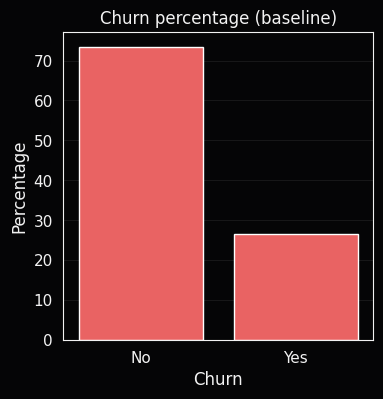

In [6]:
assert "Churn" in df.columns, "Kolom 'Churn' not found"

df["Churn"] = df["Churn"].str.strip()

churn_rate = df["Churn"].value_counts(normalize=True) * 100
print(churn_rate)

plt.figure(figsize=(4,4))
sns.barplot(x=churn_rate.index, y=churn_rate.values)
plt.ylabel("Percentage")
plt.title("Churn percentage (baseline)")
plt.show()


In [7]:
target_col = "Churn"

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != target_col]

numeric_cols, categorical_cols


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

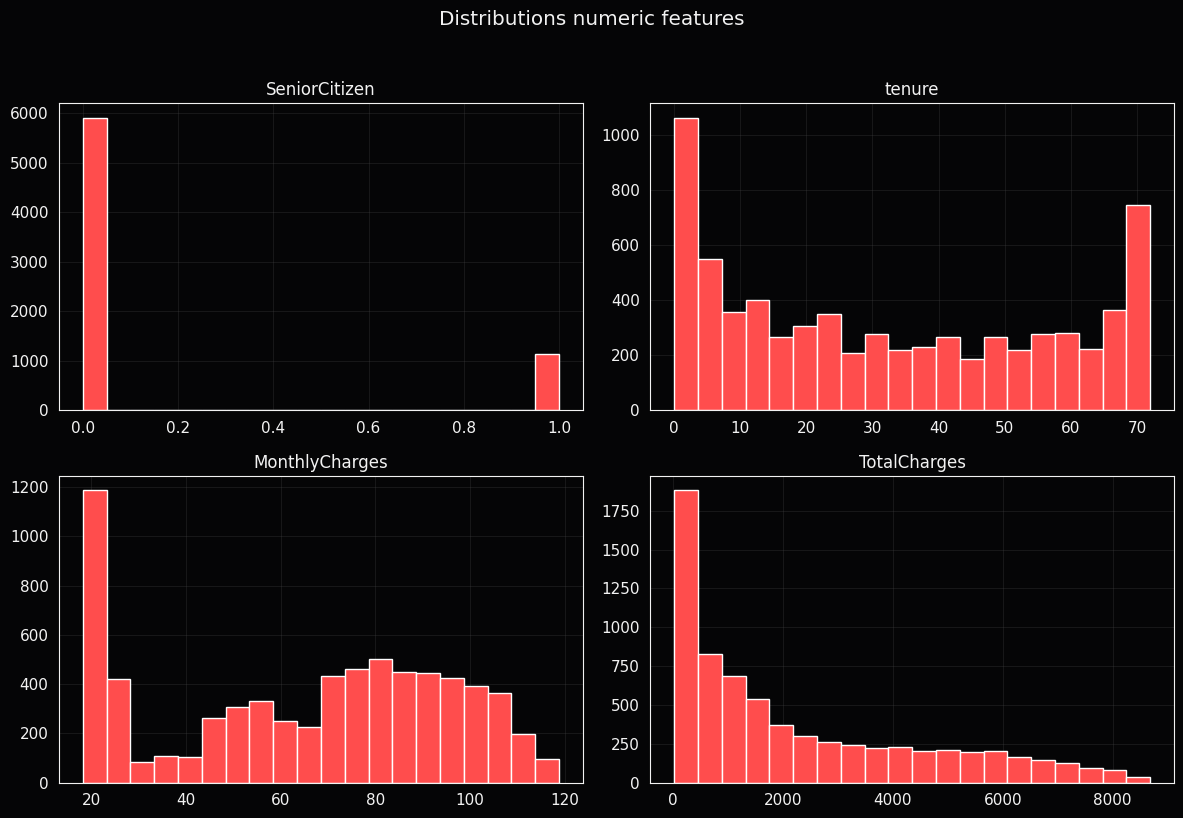

In [8]:
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions numeric features", y=1.02)
plt.tight_layout()
plt.show()


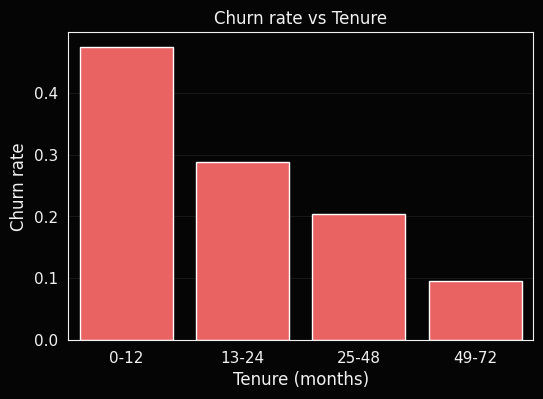

In [9]:
if "tenure" in df.columns:
    df["tenure_bin"] = pd.cut(
        df["tenure"],
        bins=[0, 12, 24, 48, 72],
        labels=["0-12", "13-24", "25-48", "49-72"],
        include_lowest=True
    )

    churn_by_tenure = (
        df.groupby("tenure_bin", observed=False)["Churn"]
        .value_counts(normalize=True)
        .rename("rate")
        .reset_index()
    )

    plt.figure(figsize=(6,4))
    sns.barplot(
        data=churn_by_tenure[churn_by_tenure["Churn"] == "Yes"],
        x="tenure_bin",
        y="rate"
    )
    plt.ylabel("Churn rate")
    plt.xlabel("Tenure (months)")
    plt.title("Churn rate vs Tenure")
    plt.show()

    churn_by_tenure


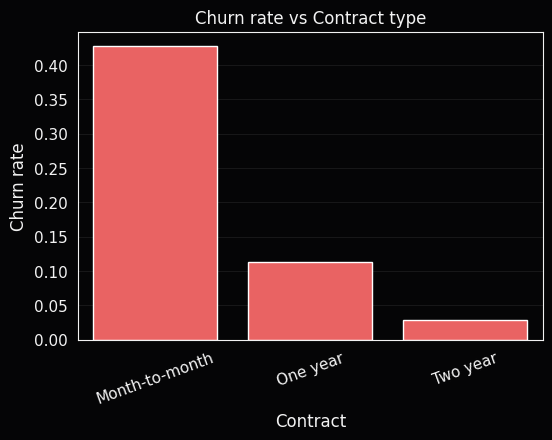

In [10]:
if "Contract" in df.columns:
    churn_by_contract = (
        df.groupby("Contract")["Churn"]
        .value_counts(normalize=True)
        .rename("rate")
        .reset_index()
    )

    plt.figure(figsize=(6,4))
    sns.barplot(
        data=churn_by_contract[churn_by_contract["Churn"] == "Yes"],
        x="Contract",
        y="rate"
    )
    plt.ylabel("Churn rate")
    plt.title("Churn rate vs Contract type")
    plt.xticks(rotation=20)
    plt.show()

    churn_by_contract


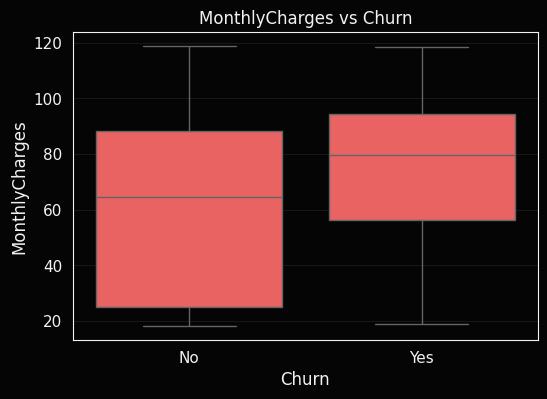

In [11]:
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
    plt.title("MonthlyCharges vs Churn")
    plt.show()


## Quickscan – Observations

- **Baseline churn**: ~73.5% of the customers has label "Yes".
- **Tenure < 12 months**: clearly higher churn-rate than long-term contracts.
- **Contracttype**:
  - **Month-to-month** higher churn-rate than 1- or 2-year contracts.
- **Monthly consts**:
  - Customers who churn have on average higher `MonthlyCharges` than customers who stay.

These three form the first business narrative:
focus on **new customers**, **short-term contracts** and **high-ARPU customers**.
